In [954]:
import torch
import einops
import math

from dataclasses import dataclass


from utils.config import NetworkConfig
from utils.model import WeatherField

In [955]:
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def compute_strides(layout: tuple, sizes: dict):
    strides = {}
    stride = 1
    for ax in reversed(layout):
        strides[ax] = stride
        stride *= sizes[ax]
    return strides
    
def index_to_coords(idx: torch.LongTensor, layout: tuple, strides: dict):
    coords = []
    for ax in layout:
        val = idx.div(strides[ax], rounding_mode="floor")
        idx = idx.fmod(strides[ax])
        coords.append(val)
    return torch.stack(coords, dim=-1) 

def coords_to_index(coords: torch.LongTensor, layout: tuple, strides: dict):
    return sum(coords[..., i] * strides[ax] for i, ax in enumerate(layout)) 

@dataclass
class WorldConfig:
    field_layout: tuple
    patch_layout: tuple
    field_sizes: dict
    patch_sizes: dict
    batch_size: int
    tau: int
    alphas: dict
    score_weights: dict

@dataclass
class ConfigWrapper:
    world : WorldConfig
    network : NetworkConfig

In [1380]:
model_cfg = NetworkConfig(
    dim = 512, 
    num_layers=12, 
    dim_in = 96,
    dim_out = 96,
    wavelengths=[(1e-3, 1e2,), (1e-3, 1e2,), (1e-3, 1e2,)], 
    num_features= 8, 
    num_latents=256)

world_cfg = WorldConfig(
    field_layout = ('v', 't', 'h', 'w'),
    patch_layout = ('vv', 'tt', 'hh', 'ww'),
    field_sizes = {'v': 8, 't': 36, 'h': 64, 'w': 120},
    patch_sizes = {'vv': 1, 'tt': 6, 'hh': 8, 'ww': 10},
    batch_size = 1000,
    tau = 2,
    score_weights = {'t': 4., 'v': 1},
    alphas = {'t': 1., 'v': 8}  # Dirichlet prior concentration parameters
)

cfg = ConfigWrapper(
    world = world_cfg,
    network = model_cfg
)

In [1398]:
class MaskedField(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self._cfg = cfg.world
        self.device_type: str = 'cpu'
        self.device: torch.DeviceObjType = torch.device('cpu')
        self.network = WeatherField(cfg.network)

    ### SHAPES
    @property
    def batch_size(self): 
        return self._cfg.batch_size

    @property # field sizes per axis from config
    def field_sizes(self): 
        return self._cfg.field_sizes

    @property # patch sizes per axis from config
    def patch_sizes(self): 
        return self._cfg.patch_sizes
    
    @property # patch counts per axis derived from field and patch sizes
    def token_sizes(self): 
        return {ax: (self.field_sizes[ax] // self.patch_sizes[f'{ax*2}']) for ax in self.field_layout}
    
    @property
    def num_tokens(self): # total number of patches in the flatland representation
        return math.prod([self.token_sizes[t] for t in self.field_layout])

    @property
    def dim_tokens(self):  # total number of values in a single patch
        return math.prod([self.patch_sizes[p] for p in self.patch_layout])

    @property # arrangement of axes in the unpatched field 
    def field_layout(self): 
        return self._cfg.field_layout
    
    @property # arrangement of axes in the patch dimension
    def patch_layout(self): 
        return self._cfg.patch_layout

    @property # einops pattern for the unpatched field
    def field_pattern(self): 
        field = " ".join([f"({f} {p})" for f, p in zip(self.field_layout, self.patch_layout)])
        return f"... {field}"

    @property
    def token_pattern(self):
        return ' '.join(self.field_layout)

    @property # einops pattern for the patched flatland representation
    def flatland_pattern(self): 
        patches = ' '.join(self.patch_layout)
        return f'... ({self.token_pattern}) ({patches})'
    
    ### SHAPE MANIPULATIONS
    def field_to_tokens(self, field):
        return einops.rearrange(field, f'{self.field_pattern} -> {self.flatland_pattern}', **self.patch_sizes)
    
    def tokens_to_field(self, patch):
        return einops.rearrange(patch, f"{self.flatland_pattern} -> {self.field_pattern}", **self.token_sizes, **self.patch_sizes)

    ### SAMPLING
    def sample_gumbel(self, shape: tuple, eps: float = 1e-6):
        u = torch.rand(shape, device = self.device).clamp(min=eps, max=1-eps)
        return -torch.log(-torch.log(u))
            
    def sample_dirichlet(self, alpha, shape: tuple):
        a = alpha * torch.ones(shape, device= self.device).softmax(-1)
        return torch._sample_dirichlet(a)
    
    @staticmethod
    def as_logit(p: torch.Tensor):
        eps = torch.finfo(p.dtype).eps
        p = p.clamp(min=eps, max=1 - eps) 
        return torch.log(p) - torch.log1p(-p)
    
    @staticmethod
    def as_logprob(p: torch.Tensor):
        return torch.log(p.clamp(min=torch.finfo(p.dtype).eps))

    def trunc_normal_item(self, mean, std, a, b):
        return torch.nn.init.trunc_normal_(torch.empty((1,), device= self.device), mean, std, a, b).item()
    
    ### PRIORS
    def dirichlet_marginal(self, ax: str):
        B, A = self.batch_size, self.token_sizes.get(ax, 1)
        probs = self.sample_dirichlet(self._cfg.alphas[ax], (B, A))
        probs = einops.repeat(probs, f'b {ax} -> b ({self.token_pattern})', **self.token_sizes)
        score = self.as_logprob(probs)
        return score
    
    def frcst_rate(self):
        return int(self.num_tokens  * self._cfg.tau / self.token_sizes['t'])

    def random_rate(self):
        return int(self.num_tokens * self.trunc_normal_item(0.2, 0.3, 0.05, 0.35))
    
    def frcst_score(self):
        step = torch.zeros((self.token_sizes['t'],), device=self.device)
        step[:self._cfg.tau] = float('inf')
        score = einops.repeat(step, f't -> b ({self.token_pattern})', **self.token_sizes, b=self.batch_size)
        return score
    
    def random_score(self):
        G = self.sample_gumbel((self.batch_size, self.num_tokens))
        factors = [G] + [self.dirichlet_marginal(ax) for ax in self._cfg.alphas.keys()]
        return einops.reduce(factors, f'factors ... -> ...', 'sum') 

    def get_masks(self, mode: str):
        k = self.random_rate() if mode == 'prior' else self.frcst_rate()
        score = self.random_score() if mode == 'prior' else self.frcst_score()
        indices = score.argsort(dim=-1, descending=True)
        return indices[..., :k], indices[..., k:]

In [1399]:
mf = MaskedField(cfg)

In [1400]:
B, V, T, H, W = mf.batch_size, mf.token_sizes['v'], mf.token_sizes['t'], mf.token_sizes['h'], mf.token_sizes['w']

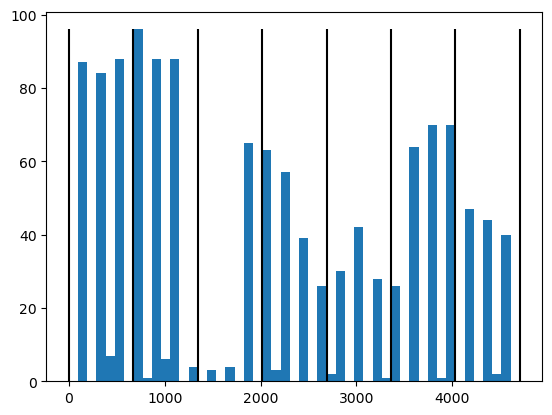

In [1405]:
src, tgt = mf.get_masks('prior') 
bins = np.arange(0, mf.num_tokens + H* W, H * W)
_ = plt.hist(src[0] , bins = bins, histtype='barstacked')
plt.vlines(np.linspace(0, mf.num_tokens+ H* W, V), 0, H*W, color = 'black')